# COMP90051 Project 2

In [2]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        abstractmethod
        """
    
    def update(self, arm, reward, context):
        '''
        get the average reward
        :param arm: NO. of arm
        :param reward: current reward
        :return: average reward
        '''
        # first round just sign with reward
        if self.values[arm] == self.Q0:
            self.values[arm] = reward
        else:
            self.values[arm] = (self.values[arm] * self.pullTime[arm] + reward) / (self.pullTime[arm] + 1)
        self.pullTime[arm] += 1

e-greedy method

In [4]:
class EpsGreedy(MAB):

    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        # pullTime[i] means The number of times the rod 'i' was pulled
        self.pullTime = np.zeros(narms)
        self.values = np.full(narms, Q0)

    def play(self, tround, context=None):
        '''
        Each time you play, you will draw a random number from 0 to 1.
        If the number is greater than 'e', play the lever that you think the winning probability is the largest.
        If it is less than ε, then randomly select a lever.
        After getting the result, update the estimated winning probability of the lever to facilitate the next selection.
        :param tround: rounds to play
        :return: best arm
        '''
        num_random = np.random.random()
        if num_random > self.epsilon:
            return np.argmax(self.values)
        else:
            return self.get_random_arm()

    def get_random_arm(self):
        '''
        get a random arm
        '''
        random_choice = np.random.choice(self.narms)
        return random_choice

UCB

In [5]:
class UCB(MAB):

    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        # pullTime[i] means The number of times the rod 'i' was pulled
        self.pullTime = np.zeros(narms)
        self.values = np.full(narms, Q0)


    def play(self, tround, context=None):
        '''
        choose the best arm when X + Y get the highest score,
        X = average of rewards of an arm
        Y = UCB score
        :return: best arm
        '''
        values = [0] * self.narms
        for i in range(self.narms):
            # first round just sign with reward
            if self.values[i] == self.Q0:
                values[i] = self.Q0
            else:
                values[i] = self.max_value(self.values[i], tround, self.pullTime[i])
        return np.argmax(values)

    def max_value(self, averageValue, tround, pullTimes):
        '''
        apply UCB formula here
        :param averageValue: average of rewards of an arm
        :param tround: rounds to play
        :param pullTimes: how many times is an arm pulled
        :return: maxValue
        '''
        bonus = np.sqrt(self.rho * np.log(tround) / pullTimes)
        maxValue = averageValue + bonus
        return maxValue

## 2. Off-Policy Evaluation

In [6]:
def read_data(filename):
    ''' get arms, rewards and context from dataset'''
    data = np.loadtxt(filename)
    arms = data[:,0] # which arm you choose
    rewards = data[:,1] # the reward for choosing the arm
    contexts = data[:,2:] # features
    return arms, rewards, contexts

In [7]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds):
    '''
    keep playing until the mab match with the data event
    :param mab: MAB method
    :param arms: the arm pulled
    :param rewards: the reward for pulling the arm
    :param contexts: features
    :param nrounds: how many rounds you play
    :return: a list of rewards
    '''
    
    currReward = [] # store current reward
    curr = 0 # record the matching process 

    for i in range(nrounds):
        # match for mab and data event
        while (not match(i, curr)):
            curr +=1
        currReward.append(rewards[curr])
        mab.update(int(arms[curr]) - 1, rewards[curr], contexts[curr])
        curr += 1
    return currReward

def match(i, curr):
    '''
    to see whether match or not
    '''
    if (mab.play(i, contexts[curr]) == int(arms[curr]) - 1):
        return True
    else:
        return False


    

Read data from dataset

In [8]:
arms, rewards, contexts = read_data('dataset.txt')

In [9]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.14


In [10]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.17625


## 3. Contextual Bandits

In [11]:
class LinUCB(MAB):

    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha

        self.Aa = [np.identity(ndims)] * narms # Aa : collection of matrix to compute disjoint part for each article a, d*d
        self.ba = [np.zeros(ndims)] * narms # ba : collection of vectors to compute disjoin part, d*1
        self.AaI = np.linalg.inv(self.Aa) # AaI : store the inverse of all Aa matrix


    def play(self, tround, context):
        '''
        Implement steps 8-11.
        We directly calculate the current optimal parameter and the confidence upper bound according to the formula,
        and select the largest arm as the recommendation result.
        There is a small trick in the code, and for all the arms,
        a feature is used together, instead of using different features for each arm separately
        :param tround: number of rounds we play
        :return: best arm
        '''
        payOffs = [0] * self.narms
        for i in range(self.narms):
            x = self.get_arm_d(i, context)
            theta = self.AaI[i] @ self.ba[i]
            payOffs[i] = (x.T @ theta) + np.sqrt(x.T @ self.AaI[i] @ x) * self.alpha
        return np.argmax(payOffs)

    def update(self, arm, reward, context):
        '''
        This corresponds to steps 12-13 in article.
        Based on the selected optimal arm and the resulting user feedback,
        we update the A and b matrices:
        '''
        if reward == 1:
            x = self.get_arm_d(arm, context)
            self.Aa[arm] = self.Aa[arm] + x @ x.T
            self.ba[arm] = self.ba[arm] + x

    def get_arm_d(self, arm, context):
        '''
        :param arm: current arm
        :param context: context for current arm
        :return: a sub-list of context, which length = n_dimensional
        '''
        features = context[arm * self.ndims : arm * self.ndims + self.ndims]
        return features


In [123]:
mab = LinUCB(10, 10, 1)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.25375


## 4. Evaluation
### 4.A.

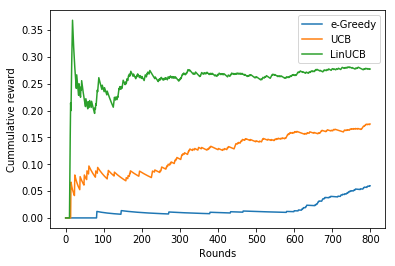

In [40]:
def result1(result):
    mab = [0]* len(result)
    for i in range(len(result)):
        mab[i] = sum(result[:i])/(i+1)
    return mab

plt.plot(result1(results_EpsGreedy), label="e-Greedy")
plt.plot(result1(results_UCB), label="UCB")
plt.plot(result1(results_LinUCB), label="LinUCB")
plt.xlabel("Rounds")
plt.ylabel("Cummulative reward")
plt.legend()
plt.show()

### 4.B.

a is  0.05 reward is  0.19125
a is  0.1 reward is  0.1925
a is  0.15 reward is  0.25
a is  0.2 reward is  0.25
a is  0.25 reward is  0.25
a is  0.3 reward is  0.24875
a is  0.35 reward is  0.25
a is  0.4 reward is  0.25
a is  0.45 reward is  0.25125
a is  0.5 reward is  0.25125
a is  0.55 reward is  0.2525
a is  0.6 reward is  0.25
a is  0.65 reward is  0.25
a is  0.7 reward is  0.2525
a is  0.75 reward is  0.25375
a is  0.8 reward is  0.25375
a is  0.85 reward is  0.25375
a is  0.9 reward is  0.25375
a is  0.95 reward is  0.25375
a is  1.0 reward is  0.25375


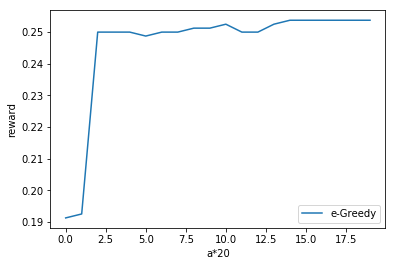

In [141]:

# mab = LinUCB(10, 10, 0.1)
def exp_lin(mab):
    return np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800))
r = []
for i in range(20):
    j = (i+1)/20
    mab = LinUCB(10, 10, j)
    result = exp_lin(mab)
    print ('a is ',j, 'reward is ',result)
    r.append(result)
plt.plot(r)
plt.xlabel("a*20")
plt.ylabel("reward")
plt.show()


So best a is choosen from {0.75 - 1.00}

## 5. KernelUCB

In [ ]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    